In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import gym

from tqdm.auto import tqdm, trange
import time

In [3]:
from tiles3 import IHT, tiles

In [4]:
iht = IHT(1024)

print(tiles(iht, 8, [3.6, 7.2]))
print(tiles(iht, 8, [3.7, 7.2]))
print(tiles(iht, 8, [4.8, 7.5]))
print(tiles(iht, 8, [4.2, 7.35]))

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 8, 4, 5, 6, 7]
[9, 10, 11, 12, 13, 14, 15, 16]
[9, 10, 17, 8, 4, 5, 6, 18]


In [5]:
max_size = 4096
iht=IHT(max_size)

x, xdot = -0.5, 0.0
a = 0
tiles(iht,8,[8*x/(0.5+1.2),8*xdot/(0.07+0.07)],[a])

[0, 1, 2, 3, 4, 5, 6, 7]

In [6]:
def scale(s):
    return [10*s[0]/(0.6+1.2),10*s[1]/(0.07+0.07)]

In [7]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 10_000
env.reset()
for step in range(100):
    env.render()
    a = 2#env.action_space.sample()
    observation, reward, done, info = env.step(a)
    
    if step % 10 == 0:
        print(observation, a, reward)
        print(tiles(iht, 8, scale(observation)), [a])
    time.sleep(0.02)
env.close()

[-0.53418156  0.00108751] 2 -1.0
[8, 9, 10, 11, 12, 13, 14, 15]
[-0.46914092  0.01024722] 2 -1.0
[8, 16, 17, 11, 18, 19, 20, 21]
[-0.34793235  0.0123599 ] 2 -1.0
[22, 23, 24, 25, 26, 19, 27, 21]
[-0.2498831   0.00681674] 2 -1.0
[22, 28, 24, 29, 30, 31, 32, 33]
[-0.2308004  -0.00228256] 2 -1.0
[34, 28, 35, 36, 30, 37, 32, 38]
[-0.30034415 -0.01025644] 2 -1.0
[34, 39, 35, 40, 41, 42, 43, 44]
[-0.42131614 -0.0124147 ] 2 -1.0
[45, 46, 47, 40, 41, 48, 49, 50]
[-0.51842481 -0.00637467] 2 -1.0
[45, 46, 10, 51, 12, 13, 52, 15]
[-0.52517373  0.00412544] 2 -1.0
[8, 9, 17, 11, 12, 53, 14, 15]
[-0.43683163  0.01172914] 2 -1.0
[8, 16, 17, 11, 26, 19, 27, 21]


In [8]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [38]:
w = np.random.randn(3, max_size)

x = tiles(iht, 8, proj(observation), [0])

In [39]:
w[0, x]

array([-0.09565594,  0.80404303, -0.74436048, -1.42027357,  0.98248993,
       -0.59229955, -0.56944993,  0.788242  ])

In [12]:
def q_hat(s,a,w):
    x = tiles(iht, 8, scale(s), [a])
    return w[a, x].sum()

In [41]:
q_hat(observation, 0, w), q_hat(observation, 1, w), q_hat(observation, 2, w)

(-0.8472645170579687, 0.9941694459846002, 6.693628469567287)

## Episodic semi-gradient Sarsa 

In [53]:
def greedy(s, w):
    return max(range(3), key=lambda a: q_hat(s, a, w))

def eps_greedy(s, w, eps=0.1):
    if random.random() < eps:
        return random.randint(0,2)
    else:
        return greedy(s, w)

In [54]:
def run_sarsa(n_episodes=10, alpha=0.2, gamma=1., eps=0.01):
    max_steps = 100_000
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((3, max_size))
    pbar = trange(n_episodes)
    for e in pbar:
        
        s = env.reset()
        a = env.action_space.sample()
        done = False
        
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            if done:
                w[a, idx] += alpha * (r - q_hat(s,a,w))
                steps_per_episode[e] = step+1
                # print(sp)
                break
            ap = eps_greedy(s, w)
            w[a, idx] += alpha * (r + gamma*q_hat(sp,ap,w) - q_hat(s,a,w))
            s, a = sp, ap
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

In [55]:
steps_per_episode, w = run_sarsa(500)

  0%|          | 0/500 [00:00<?, ?it/s]

(100.0, 1000.0)

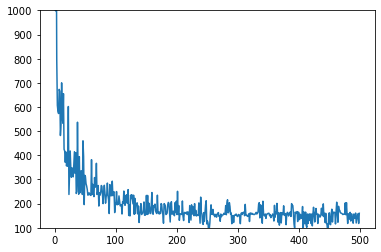

In [56]:
plt.plot(steps_per_episode)
plt.ylim([100, 1000])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

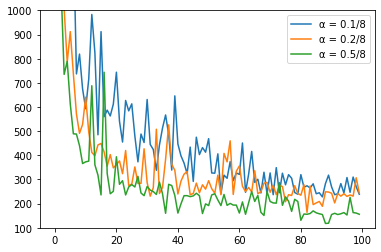

In [57]:
fig = plt.figure()

for alpha in [0.1, 0.2, 0.5]:
    steps_per_episode, w = run_sarsa(100, alpha=alpha)
    plt.plot(steps_per_episode, label=f"α = {alpha}/8")
    
plt.ylim([100, 1000])
plt.legend(loc='upper right')
plt.show()

In [52]:
s = env.reset()
done = False
total_reward = 0
while not done:
    env.render()
    # greedy policy
    a = max(range(3), key=lambda a: q_hat(s,a,w))
    s, r, done, info = env.step(a)
    total_reward += r
    time.sleep(0.01)
env.close()
print("Total reward =", total_reward)

Total reward = -123.0


In [58]:
def run_qlearning(n_episodes=10, alpha=0.2, gamma=1., eps=0.01):
    max_steps = 100_000
    steps_per_episode = np.zeros(n_episodes, )
    
    alpha /= 8
    w = np.zeros((3, max_size))
    pbar = trange(n_episodes)
    for e in pbar:
        
        s = env.reset()
        a = env.action_space.sample()
        done = False
        
        for step in range(max_steps):
            idx = tiles(iht, 8, scale(s), [a])
            sp, r, done, info = env.step(a)
            if done:
                w[a, idx] += alpha * (r - q_hat(s,a,w))
                steps_per_episode[e] = step+1
                break
            ap = eps_greedy(s, w)
            w[a, idx] += alpha * (r + gamma*max([q_hat(sp, a_, w) for a_ in range(3)]) - q_hat(s,a,w))
            s, a = sp, ap
        pbar.set_description(f"steps/ep. {steps_per_episode[e]}")
    return steps_per_episode, w

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

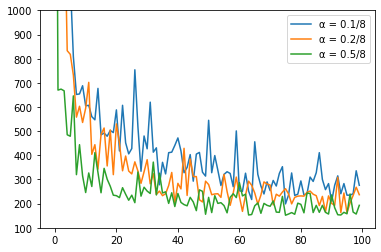

In [59]:
fig = plt.figure()

for alpha in [0.1, 0.2, 0.5]:
    steps_per_episode, w = run_qlearning(100, alpha=alpha)
    plt.plot(steps_per_episode, label=f"α = {alpha}/8")
    
plt.ylim([100, 1000])
plt.legend(loc='upper right')
plt.show()